# Balloon HDF5 Event Reader

This simple notebook shows how we can read example waveforms from an experiment consisting of antennas dangling from a balloon above Antarctica. It will illustrate how these could be turned into images for use in machine learning training.


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
import h5py


In [2]:
run=100
f = h5py.File('flight2016/hdf5/run'+str(run)+'/event'+str(run)+'.hdf5')
rungr=f['run'+str(run)]
calgr=f['calib']

In [3]:
print(calgr.keys())
timeValues=np.array(calgr['timeValues'])
print('timeValues.shape',timeValues.shape)
#print(rungr.keys())

<KeysViewHDF5 ['timeValues']>
timeValues.shape (12, 4, 774)


In [4]:
firstev=list(rungr.keys())[100]
print(firstev)
evgr=rungr[firstev]
print(evgr.keys())



def getTimesAndMillivolts(evgr,timeValues):
    adcOffset=np.array(evgr['data'].attrs['adcOffset'])
    mvScale=np.array(evgr['data'].attrs['mvScale'])
    timeOffset=np.array(evgr['data'].attrs['timeOffset'])
    timeScale=np.array(evgr['data'].attrs['timeScale'])
    validTimeInds=np.array(evgr['data'].attrs['validTimeInds'])
    chips=np.array(evgr['data'].attrs['chips'])
    data=np.array(evgr['data'])
    adcOffset= np.reshape(adcOffset, (adcOffset.shape[0], adcOffset.shape[1],-1))
    mvScale= np.reshape(mvScale, (mvScale.shape[0], mvScale.shape[1],-1))
    timeOffset= np.reshape(timeOffset, (timeOffset.shape[0], timeOffset.shape[1],-1))
    timeScale= np.reshape(timeScale, (timeScale.shape[0], timeScale.shape[1],-1))
    
    print(chips)
    data=mvScale*(data-adcOffset)
    times=np.zeros((12,9,250))  #Times for all the waveforms
    N=np.zeros((12,9),dtype=int)
    for surf in range(12):
        for chan in range(9):
            times[surf][chan][0:validTimeInds[surf][1]-validTimeInds[surf][0]]=timeValues[surf][chips[surf]][validTimeInds[surf][0]:validTimeInds[surf][1]]
            times[surf][chan][:]=times[surf][chan][:]-times[surf][chan][0]
            N[surf][chan]=validTimeInds[surf][1]-validTimeInds[surf][0]
  
    #times=(times*timeScale)+timeOffset
    return N,times,data




ev_14402401
<KeysViewHDF5 ['data']>


[0 0 0 0 0 0 0 0 0 0 0 0]


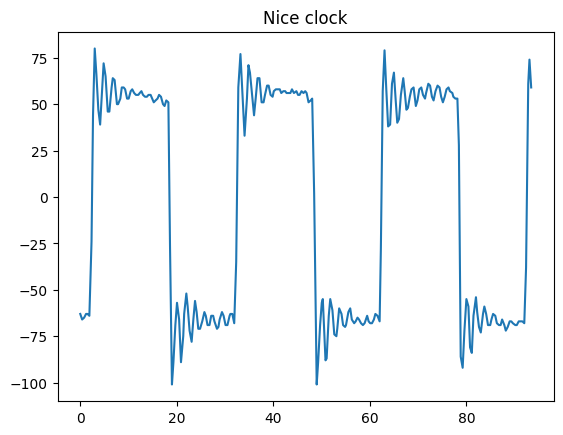

In [5]:

N,times,data=getTimesAndMillivolts(evgr,timeValues)

def getSurfChanTD(N,times,data,surf,chan):
    return times[surf][chan][0:N[surf][chan]],data[surf][chan][0:N[surf][chan]]


fig,ax = plt.subplots()
ax.set_title("Nice clock")
T,D=getSurfChanTD(N,times,data,0,8)
ax.plot(T,D)

In [6]:
print(evgr['data'].attrs.keys())

print(evgr['data'].attrs['distToWais'])



<KeysViewHDF5 ['adcOffset', 'altitude', 'attFlag', 'brms', 'chips', 'distToWais', 'eventNumber', 'goodTimeFlag', 'heading', 'l3TrigPattern', 'l3TrigPatternH', 'latitude', 'longitude', 'mrms', 'mvScale', 'phiTrigMask', 'phiTrigMaskH', 'pitch', 'priority', 'roll', 'timeOffset', 'timeScale', 'triggerTime', 'triggerTimeNs', 'validTimeInds']>
10281576.099227726


In [7]:
import anitageom
myGeom=anitageom.AnitaGeom()
print(myGeom.antToSurfMap)
print(myGeom.vAntToChan)

[11  5 10  4 11  4 10  5 11  5 10  4 11  4 10  5  9  3  8  2  8  3  9  2
  9  3  8  2  8  3  9  2  6  0  7  1  6  1  7  0  6  0  7  1  6  1  7  0]
[3 1 3 5 1 3 1 3 2 0 2 0 0 2 0 2 1 3 1 3 3 1 3 1 0 2 0 2 2 0 2 0 3 1 3 1 1
 3 1 3 2 0 2 0 0 2 0 2]


In [8]:
vImage=np.zeros((48,250))
for row in range(48):
    vImage[row]=data[myGeom.antToSurfMap[row]][myGeom.vAntToChan[row]]



Text(0, 0.5, 'Antenna Number')

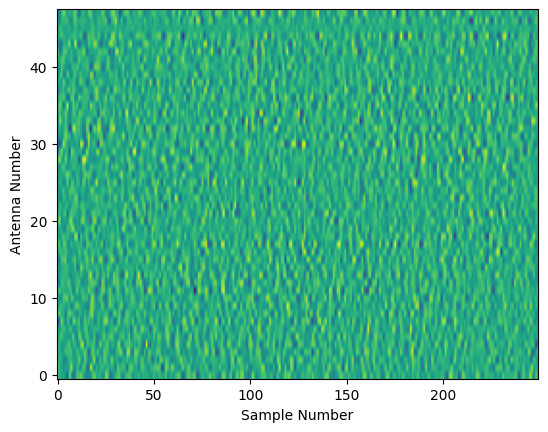

In [9]:
fig,ax = plt.subplots()
ax.imshow(vImage,aspect=4,origin='lower')
ax.set_xlabel("Sample Number")
ax.set_ylabel("Antenna Number")